<a href="https://colab.research.google.com/github/ssudhanshu488/Vit_Image_Classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [ ]:
#setting parameters
batch_size = 128
num_epochs = 50
learning_rate = 1e-4
data_set_root = "../../datasets"
patch_size = 16

In [ ]:
import kagglehub
import os
import shutil

# Define the current working directory
current_dir = os.getcwd()

# Download the dataset using kagglehub
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

# Move the dataset to the current directory if needed
if path != current_dir:
    shutil.move(path, current_dir)

print("Path to dataset files:", current_dir)


100%|██████████| 346M/346M [00:03<00:00, 99.4MB/s]

Extracting files...


Path to dataset files: /content


In [ ]:
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch


train_data_path = "/content/2/seg_train/seg_train"
test_data_path = "/content/2/seg_test/seg_test"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder(root=train_data_path, transform=transform)

validation_split = 0.1

n_train_examples = int(len(train_data) * (1 - validation_split))
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples],
                                      generator=torch.Generator().manual_seed(42))

test_data = datasets.ImageFolder(root=test_data_path, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Training samples: {n_train_examples}")
print(f"Validation samples: {n_valid_examples}")
print(f"Test samples: {len(test_data)}")


Training samples: 12630
Validation samples: 1404
Test samples: 3000


In [ ]:
def extract_patches(image_tensor, patch_size=8):
    bs, c, h, w = image_tensor.size()
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    unfolded = unfold(image_tensor)
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    return unfolded

In [ ]:
dataiter = next(iter(test_loader))
test_images, test_labels = dataiter

In [ ]:
dataiter = next(iter(train_loader))
train_images, train_labels = dataiter

Sequence Length 64


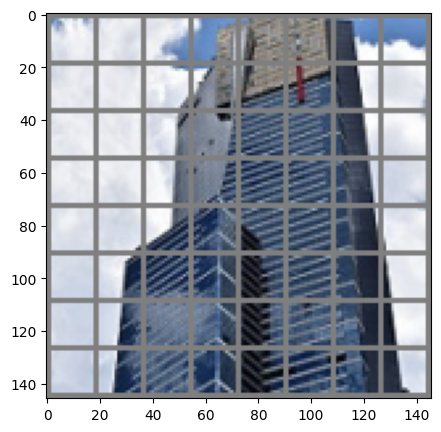

In [ ]:

patches = extract_patches(test_images, patch_size=patch_size)

patches_square = patches.reshape(test_images.shape[0], -1, 3, patch_size, patch_size)

grid_size = test_images.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches_square[0], grid_size, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4):

        super(TransformerBlock, self).__init__()

        self.norm1 = nn.LayerNorm(hidden_size)

        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads,
                                                    batch_first=True, dropout=0.1)

        self.norm2 = nn.LayerNorm(hidden_size)

        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.ELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )

    def forward(self, x):
        norm_x = self.norm1(x)

        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x

        norm_x = self.norm2(x)

        x = self.mlp(norm_x) + x

        return x


class ViT(nn.Module):
    def __init__(self, image_size, channels_in, patch_size, hidden_size, num_layers, num_heads=8):
        super(ViT, self).__init__()

        self.patch_size = patch_size

        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)

        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        self.fc_out = nn.Linear(hidden_size, 10)

        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))

        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.001))

    def forward(self, image):
        bs = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)

        patch_emb = self.fc_in(patch_seq)

        patch_emb = patch_emb + self.pos_embedding

        embs = torch.cat((self.out_vec.expand(bs, 1, -1), patch_emb), 1)

        for block in self.blocks:
            embs = block(embs)

        return self.fc_out(embs[:, 0])

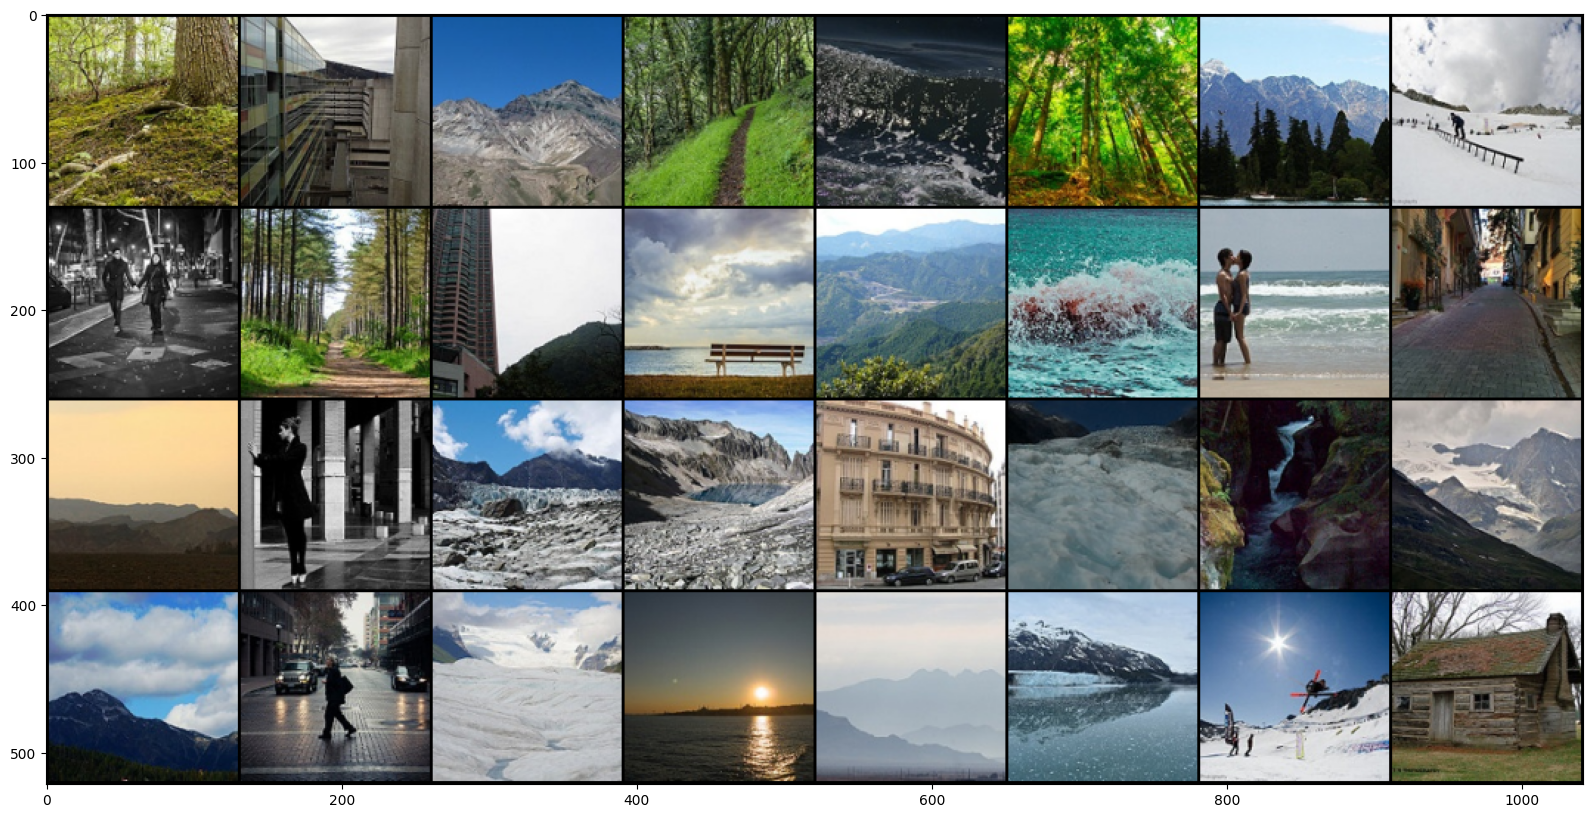

In [ ]:
lt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(train_images, 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
model = ViT(image_size=test_images.shape[2],
            channels_in=test_images.shape[1],
            patch_size=patch_size,
            hidden_size=128,
            num_layers=8,
            num_heads=8).to(device)
print(model)

ViT(
  (fc_in): Linear(in_features=768, out_features=128, bias=True)
  (blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 1171978 (Approximately 1 Million) Parameters!


In [ ]:
out = model(test_images.to(device))
out.shape

torch.Size([32, 10])

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=num_epochs,
                                                    eta_min=0)

In [ ]:
loss_fun = nn.CrossEntropyLoss()

In [ ]:
def train(model, optimizer, loader, device, loss_fun, loss_logger):

    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        fx = model(x.to(device))

        loss = loss_fun(fx, y.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_logger.append(loss.item())

    return model, optimizer, loss_logger

In [ ]:
def evaluate(model, device, loader):

    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            fx = model(x.to(device))
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()

    return epoch_acc / len(loader.dataset)

In [ ]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []

In [ ]:
valid_acc = 0
train_acc = 0

pbar = trange(0, num_epochs, leave=False, desc="Epoch")
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))

    model, optimizer, training_loss_logger = train(model=model,
                                                   optimizer=optimizer,
                                                   loader=train_loader,
                                                   device=device,
                                                   loss_fun=loss_fun,
                                                   loss_logger=training_loss_logger)

    train_acc = evaluate(model=model, device=device, loader=train_loader)
    valid_acc = evaluate(model=model, device=device, loader=valid_loader)

    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)

    lr_scheduler.step()

print("Training Complete")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/395 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Training Complete


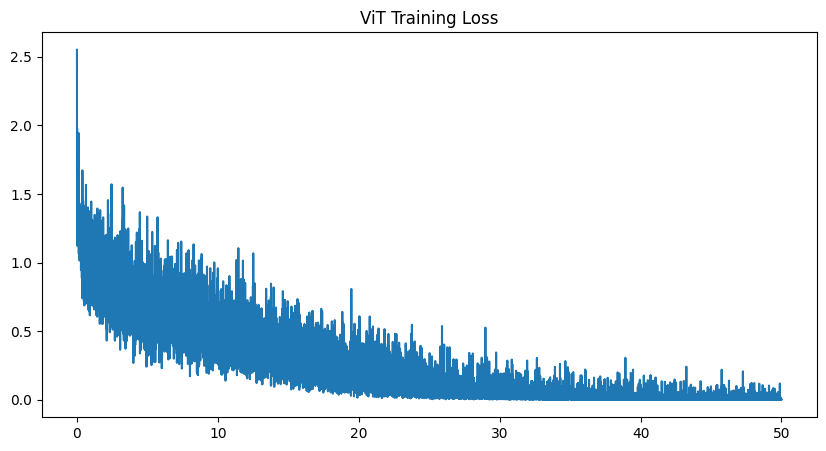

In [ ]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
_ = plt.title("ViT Training Loss")

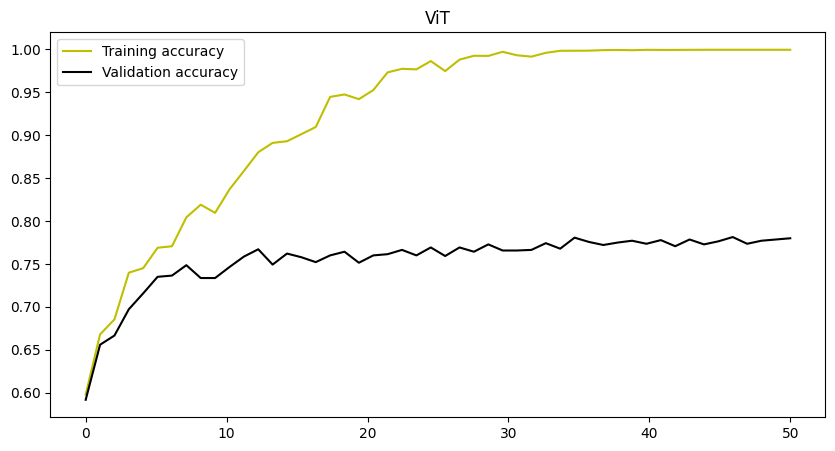

In [ ]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("ViT")
_ = plt.legend(["Training accuracy", "Validation accuracy"])

In [ ]:
test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

The total test accuracy is: 75.77%


Predicted Values
 [0, 0, 0, 0, 0, 2, 0, 5]
True Values
 [0, 0, 0, 0, 0, 0, 0, 0]


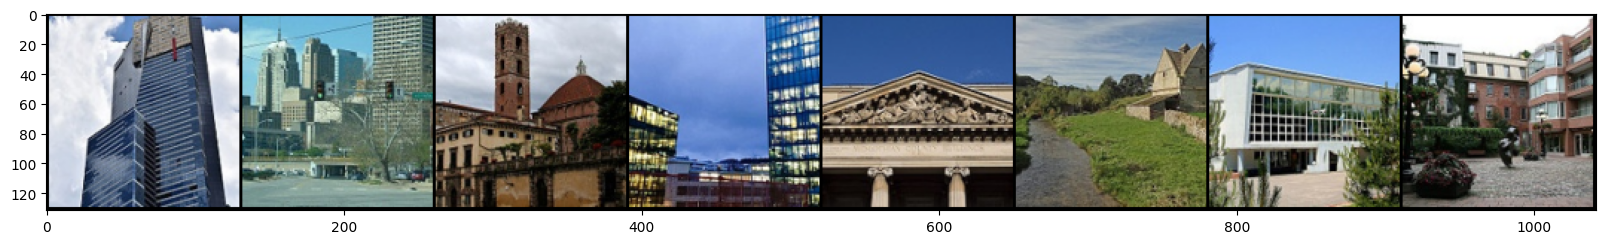

In [ ]:
with torch.no_grad():
    fx = model(test_images[:8].to(device))
    pred = fx.argmax(-1)

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))